In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [13]:
# %aimport experiments
import experiments as meas

In [14]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [15]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path=os.getcwd()+'\data\data_230217'
expt_path=os.getcwd()+'\data\data_230707'
print('Data will be stored in', expt_path)

Data will be stored in c:\_Lib\python\rfsoc\qram_4QR2_BF5\data\data_230707


In [56]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be c:\_Lib\python\rfsoc\qram_4QR2_BF5\config_q3diamond_full688and638_reset.yml


Load config

In [62]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [58]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

In [59]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [20]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

Baseline qspec

In [ ]:
qfreqs = []
qubit0 = 1
for qubit1 in range(1):
# for qubit0 in range(4):
    qspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}",
        config_file=config_path,
    )
    
    span = 15
    npts = 151
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit0]-span/2,
        # start=3600,
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=20, # Number of start to finish sweeps to average over
        pulseB=True, # Whether to apply pi pulse to qubit B
        length=1, # qubit 0 probe constant pulse length [us]
        gain=int(qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
        pulse_type='gauss',
        qubits=[qubit0, qubit1],
    )
    
    # qspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
    
    # print(qspec.cfg)
    
    qspec.go(analyze=False, display=False, progress=True, save=False)

    # ============ POST PROCESSING ============ #
    best_signs = [1, 0, 0]
    best_fit_err_i = np.inf
    best_fit_err_q = np.inf
    for sign in [1, -1]:
        try: 
            qspec.analyze(fit=True, signs=[1, sign, sign])
            fit_err_amps = qspec.data['fit_err_amps'][2][2]
            fit_err_i = qspec.data['fit_err_avgi'][2][2]
            fit_err_q = qspec.data['fit_err_avgq'][2][2]
            if fit_err_i < best_fit_err_i:
                best_signs[1] = sign
                best_fit_err_i = fit_err_i
            if fit_err_q < best_fit_err_q:
                best_signs[2] = sign
                best_fit_err_q = fit_err_q
        except: continue
    if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        qspec.display(fit=False)
        print(f'WARNING: All fits failed for Q{qubit0}, please manually fix!')
        continue

    qspec.analyze(fit=True, signs=best_signs)
    qspec.display(fit=True, signs=best_signs)

    qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
    qfreqs.append(qspec_fit[2])
    print(f'Fit Q{qubit0} frequency [MHz]: {qspec_fit[2]}')

print('Qubit freqs', qfreqs)

ZZ shifts

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4131.140797154326, HWHM 0.3105854384762209
Found peak in I at [MHz] 4131.071497968339, HWHM 0.2780009103712489
Found peak in Q at [MHz] 4131.187253945934, HWHM 0.3157764228574845


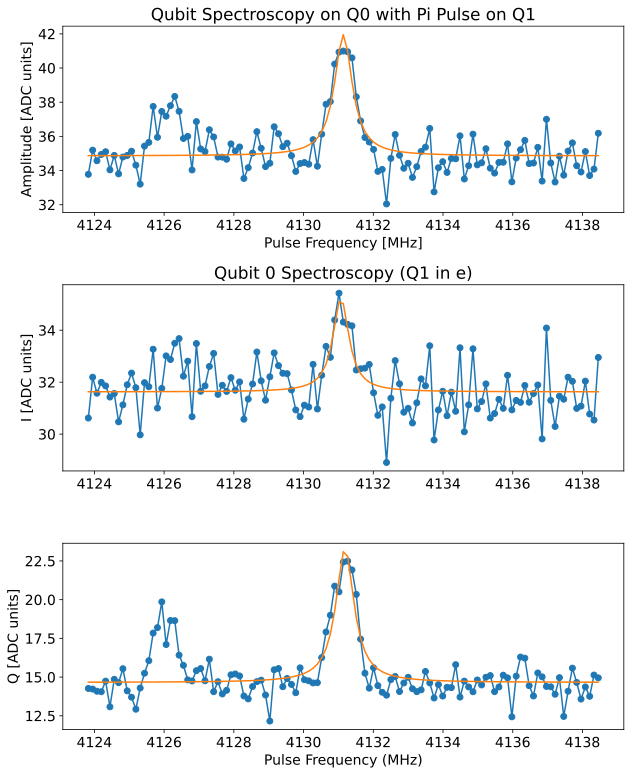

Fit Q0 frequency with ZZ shift [MHz]: 4131.187253945934
Q0 shift due to Q1 in e [MHz]: -0.014933008549633087


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4130.972932991142, HWHM -0.32059102690566404
Found peak in I at [MHz] 4130.973352545954, HWHM 0.336031867660607
Found peak in Q at [MHz] 4130.977816897983, HWHM 0.3326007778929327


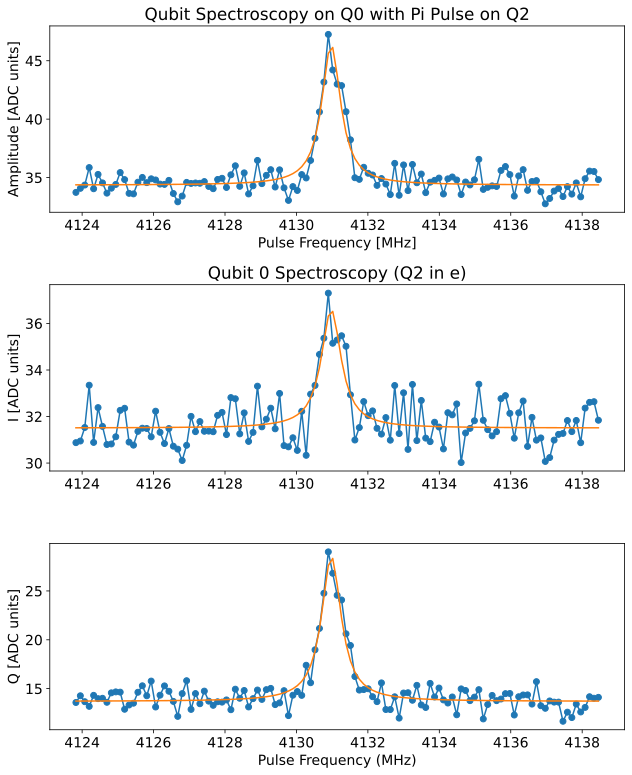

Fit Q0 frequency with ZZ shift [MHz]: 4130.972932991142
Q0 shift due to Q2 in e [MHz]: -0.22925396334085235


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4130.614815198845, HWHM 0.32239242560863635
Found peak in I at [MHz] 4130.619035924327, HWHM 0.2691641437138016
Found peak in Q at [MHz] 4130.61526691652, HWHM -0.36781139739327395


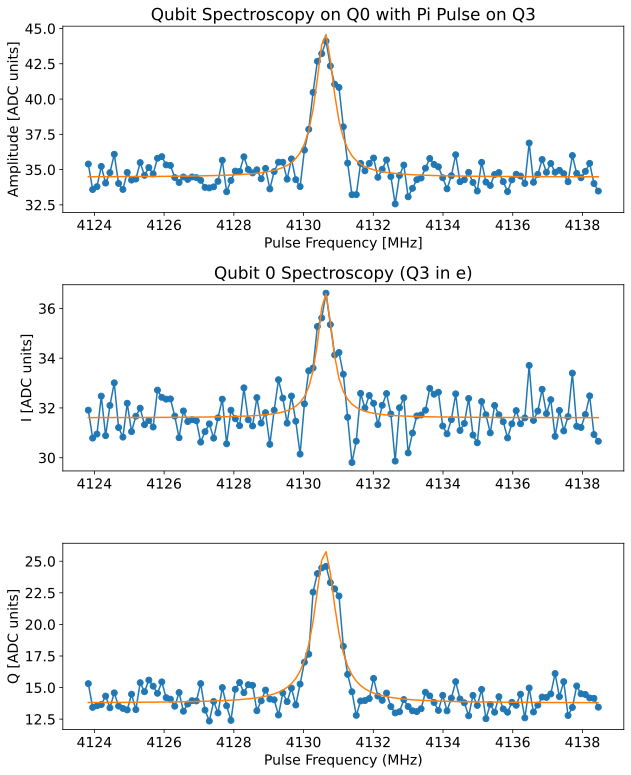

Fit Q0 frequency with ZZ shift [MHz]: 4130.61526691652
Q0 shift due to Q3 in e [MHz]: -0.5869200379629547


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3455.862488755784, HWHM 0.3314114075441304
Found peak in I at [MHz] 3455.8765156311833, HWHM 0.3629538733656359
Found peak in Q at [MHz] 3455.8559178660184, HWHM -0.3285142712313522


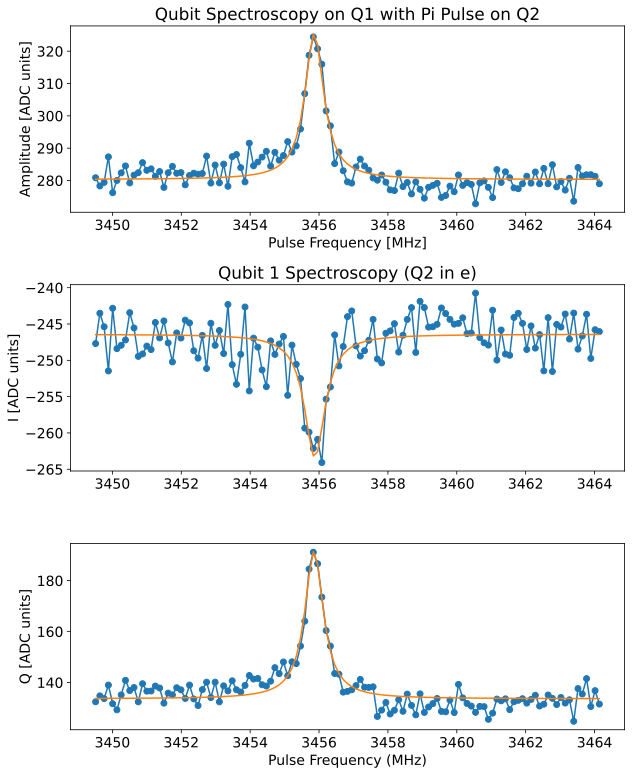

Fit Q1 frequency with ZZ shift [MHz]: 3455.8559178660184
Q1 shift due to Q2 in e [MHz]: -1.0317205458959506


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3455.618058464394, HWHM 0.39222176856669
Found peak in I at [MHz] 3455.6206678159324, HWHM 0.38752718116534096
Found peak in Q at [MHz] 3455.594084084005, HWHM 0.46419042944975586


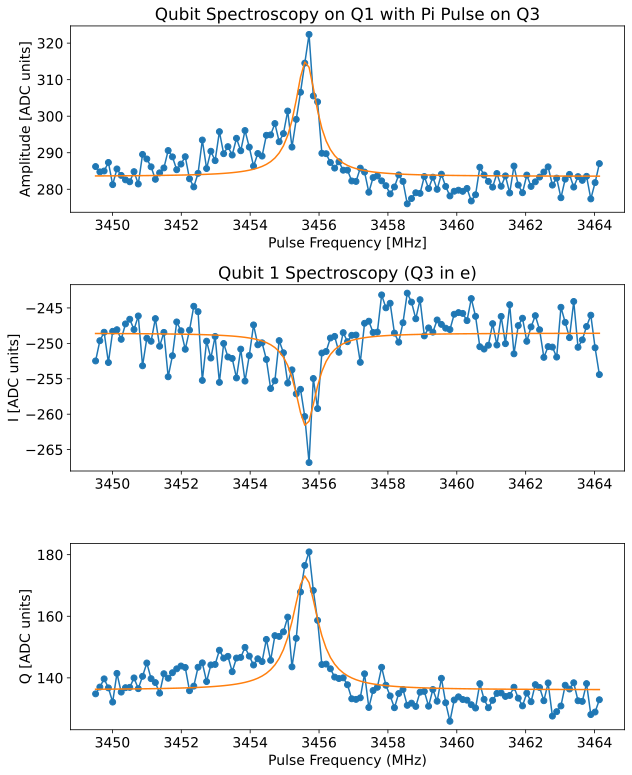

Fit Q1 frequency with ZZ shift [MHz]: 3455.594084084005
Q1 shift due to Q3 in e [MHz]: -1.2935543279095327


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4784.767998407908, HWHM 0.22202300444775652
Found peak in I at [MHz] 4784.764387362142, HWHM -0.27844265892824893
Found peak in Q at [MHz] 4784.767337186228, HWHM -0.27505932768812597


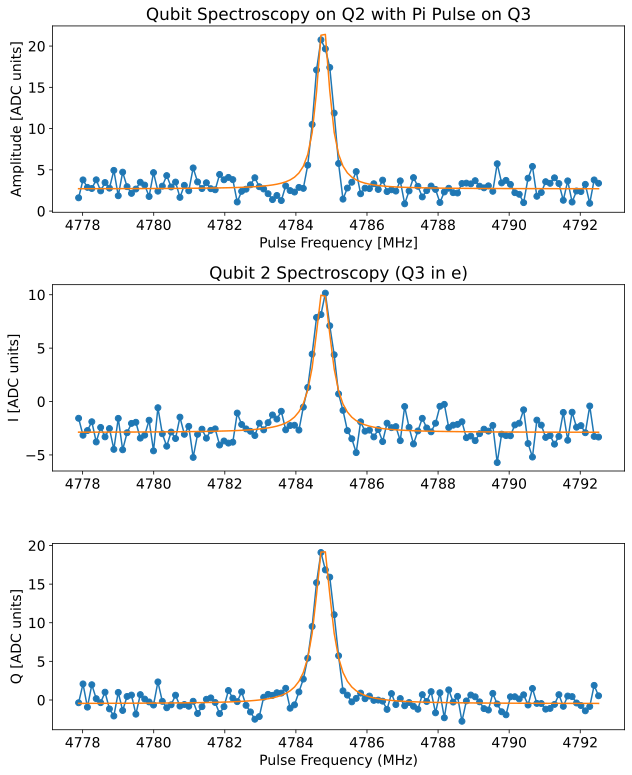

Fit Q2 frequency with ZZ shift [MHz]: 4784.767337186228
Q2 shift due to Q3 in e [MHz]: -0.49538999449760013
[[ 0.         -0.01493301 -0.22925396 -0.58692004]
 [-5.25370571  0.         -1.03172055 -1.29355433]
 [ 0.         -1.08915253  0.         -0.49538999]
 [ 0.         -1.25611137  0.          0.        ]]


In [45]:
for qubit0 in range(4): # qubit to measure
# for qubit0 in range(1): # qubit to measure
    # for qubit1 in range(2): # qubit to pulse to e
    # for qubit1 in range(4): # qubit to pulse to e
    for qubit1 in range(qubit0+1, 4):
        # if qubit0 != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 15
        npts = 121
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=1, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/5), # pulse gain for qubit we are measuring
            pulse_type='gauss',
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qubit0} due to Q{qubit1} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [46]:
ZZshifts[0, 1] = 4125.998679041251 - 4131.202186954483
ZZshifts[0, 2] = -0.22925396
ZZshifts[0, 3] = -0.58692004
ZZshifts[2, 0] = -0.22925396
ZZshifts[2, 1] = 4784.023574653984 + 0.15 - 4785.262727180726
ZZshifts[2, 3] = -0.49538999
ZZshifts[3, 0] = -0.58692004
ZZshifts[3, 2] = -0.49538999
print(ZZshifts)

[[ 0.         -5.20350791 -0.22925396 -0.58692004]
 [-5.25370571  0.         -1.03172055 -1.29355433]
 [-0.22925396 -1.08915253  0.         -0.49538999]
 [-0.58692004 -1.25611137 -0.49538999  0.        ]]


In [47]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.203507913231988, -0.22925396, -0.58692004, -5.253705713908403, 0.0, -1.0317205458959506, -1.2935543279095327, -0.22925396, -1.0891525267425095, 0.0, -0.49538999, -0.58692004, -1.2561113673027648, -0.49538999, 0.0]


In [48]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]).flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3451.633932698006, 3456.8876384119144, 3455.8559178660184, 3455.594084084005]


# Get couplings by optimization

In [40]:
sys.path.append(os.getcwd()+'/../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [17]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [41]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)

In [49]:
x0 = np.array([100, 100, 100, 10, 10, 10])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds , method='L-BFGS-B')

qubit freqs [4131.20218695 3456.88763841 4785.26272718 4398.19230406]
alphas [-225.20112662 -101.12612956 -189.56502534 -172.53752976]


In [50]:
print(f'Success: {result.success}')
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]: {1e3*result.x}')
gs_opt = result.x

Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [54.98834995 55.21613685 44.21773961  7.06638874  2.63846655  6.19737439]


In [51]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.20350791 -0.22925396 -0.58692004]
 [-5.25370571  0.         -1.03172055 -1.29355433]
 [-0.22925396 -1.08915253  0.         -0.49538999]
 [-0.58692004 -1.25611137 -0.49538999  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -5.22860701 -0.22925306 -0.58691896]
 [-5.22860701  0.         -1.06043616 -1.27483358]
 [-0.22925306 -1.06043616  0.         -0.49538898]
 [-0.58691896 -1.27483358 -0.49538898  0.        ]]
Optimization error: 0.0036101134652711565


# ZZ shifted pi pulse calibrations for Q1

In [52]:
save_data = False
saved_files = []

In [60]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 0 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.4282897103576533
Pi length from avgi data [us]: 0.019375441448129846
	Pi/2 length from avgi data [us]: 0.009687720724064923

Decay from avgq [us] 0.40743277778022624
Pi length from avgq data [us]: 0.01967356053205906
Pi/2 length from avgq data [us]: 0.00983678026602953


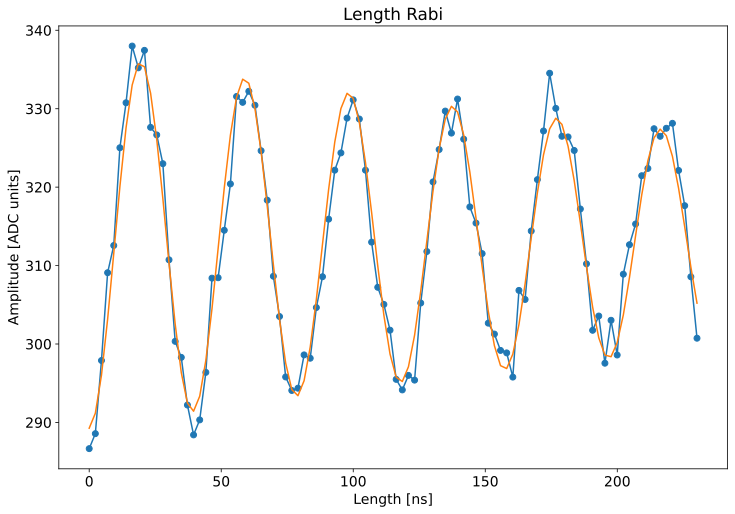

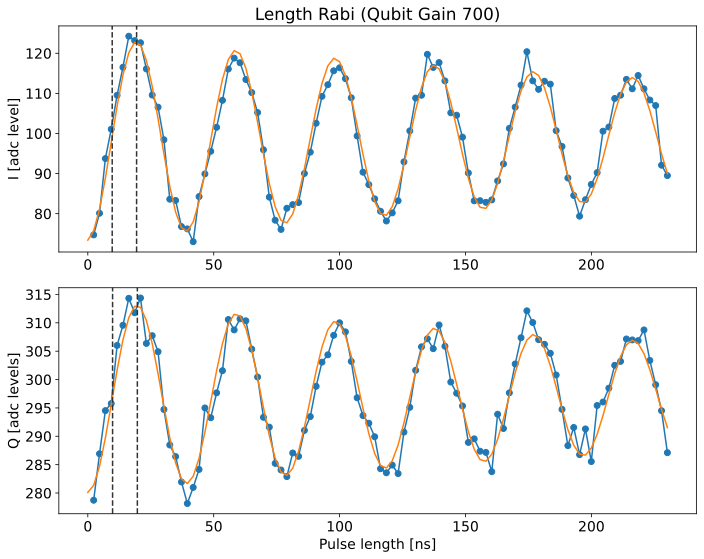

Will use sigma 0.017437897303316862 for amplitude rabi
-------- Amp rabi --------


  0%|          | 0/30 [00:00<?, ?it/s]

834
Attempted to init fitparam 4 to 102.73949775608875, which is out of bounds 278.18822719262573 to 315.590497627762. Instead init to 296.8893624101938
Pi gain from amps data [dac units]: 934
	Pi/2 gain from amps data [dac units]: 467
Pi gain from avgi data [dac units]: 934
	Pi/2 gain from avgi data [dac units]: 467
Pi gain from avgq data [dac units]: 864
	Pi/2 gain from avgq data [dac units]: 432


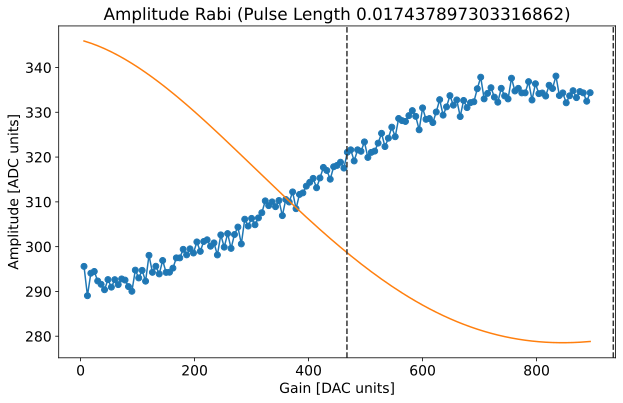

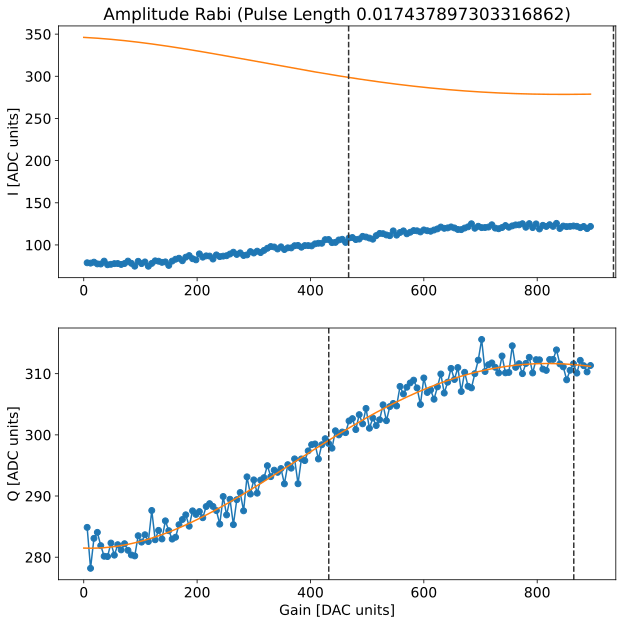

*Set Q1 pi pulse sigma with Q0 in e to 0.017437897303316862*
*Set Q1 pi pulse gain with Q0 in e to 864*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 3451.633932698006
Fit frequency from amps [MHz]: 1.4252421283065537 +/- 0.001420184855747277
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3451.2086905696992
 	3449.2086905696992
T2 Ramsey from fit amps [us]: 8.879781860858078
Current pi pulse frequency: 3451.633932698006
Fit frequency from I [MHz]: 1.424161122013028 +/- 0.0015444085414728526
Suggested new pi pulse frequency from fit I [MHz]:
 	3451.209771575993
 	3449.209771575993
T2 Ramsey from fit I [us]: 9.347014279711265
Fit frequency from Q [MHz]: 1.4258526101394051 +/- 0.0015991742971061098
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3451.2080800878666
 	3449.2080800878666
T2 Ramsey from fit Q [us]: 8.708346014024213


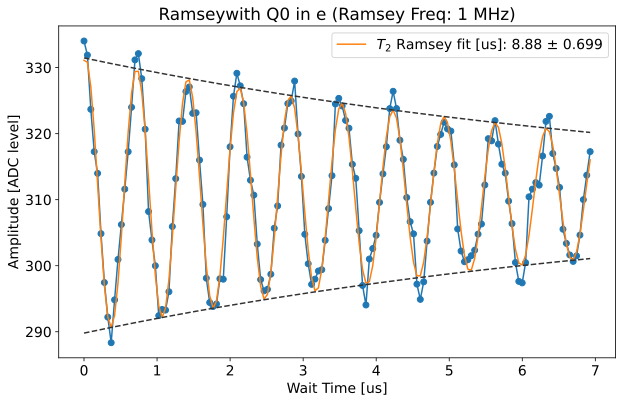

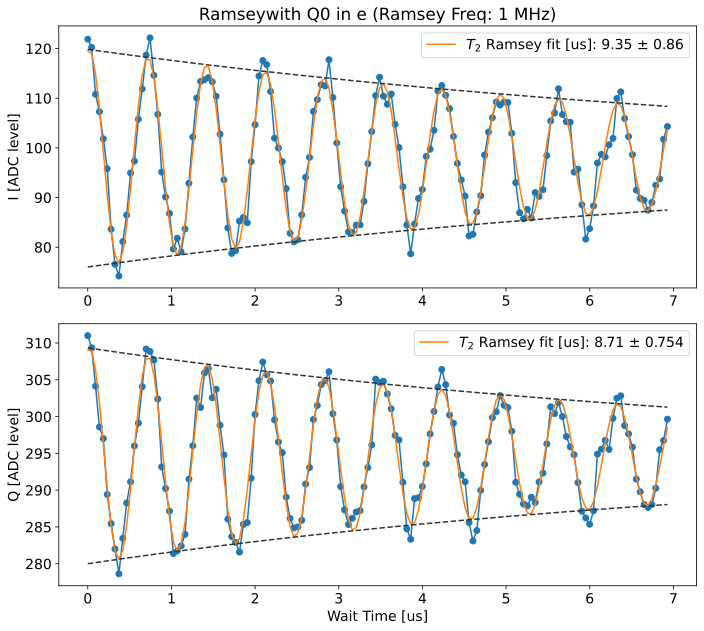

*Set Q1 pi pulse freq with Q0 in e to 3451.209771575993*



######### BEGINNING QUBIT 2 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.41033718716335127
Pi length from avgi data [us]: 0.01883029927421736
	Pi/2 length from avgi data [us]: 0.00941514963710868

Decay from avgq [us] 0.06905691964285715
Pi length from avgq data [us]: 0.02640934882089256
Pi/2 length from avgq data [us]: 0.01320467441044628


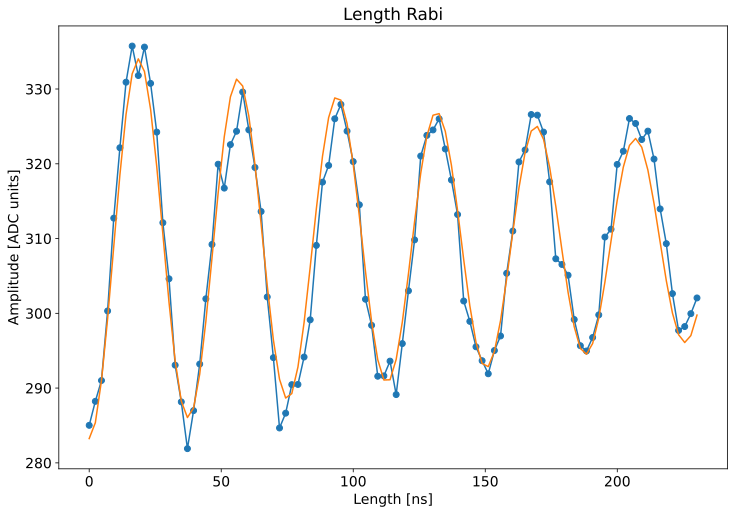

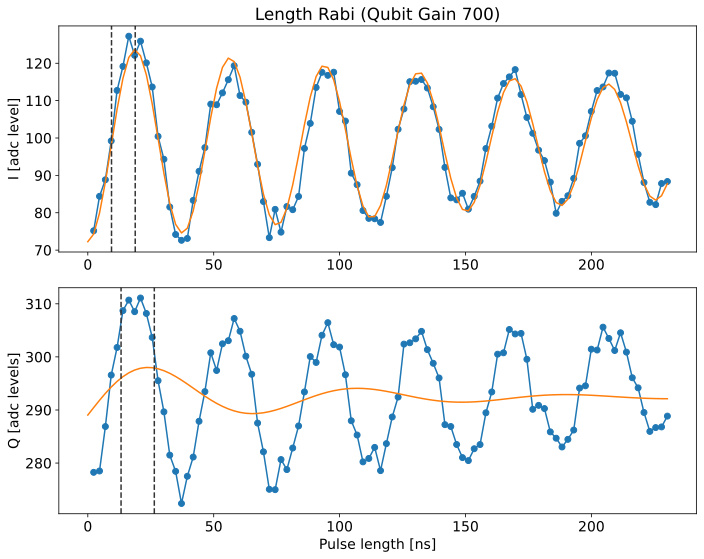

Will use sigma 0.016947269346795624 for amplitude rabi
-------- Amp rabi --------


  0%|          | 0/30 [00:00<?, ?it/s]

852
Attempted to init fitparam 4 to 102.58711804166101, which is out of bounds 276.2215423613935 to 312.0097286159686. Instead init to 294.11563548868105
Pi gain from amps data [dac units]: 796
	Pi/2 gain from amps data [dac units]: 398
Pi gain from avgi data [dac units]: 794
	Pi/2 gain from avgi data [dac units]: 397
Pi gain from avgq data [dac units]: 803
	Pi/2 gain from avgq data [dac units]: 401


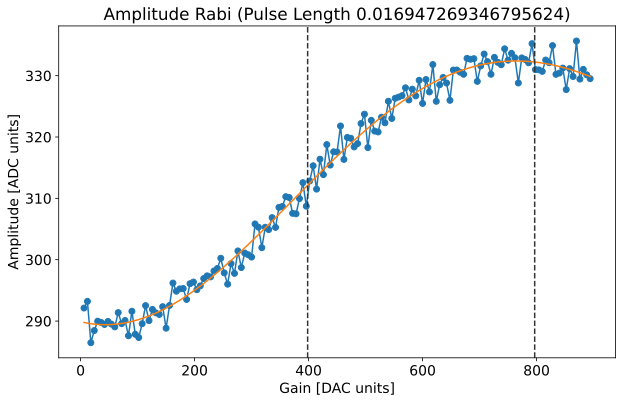

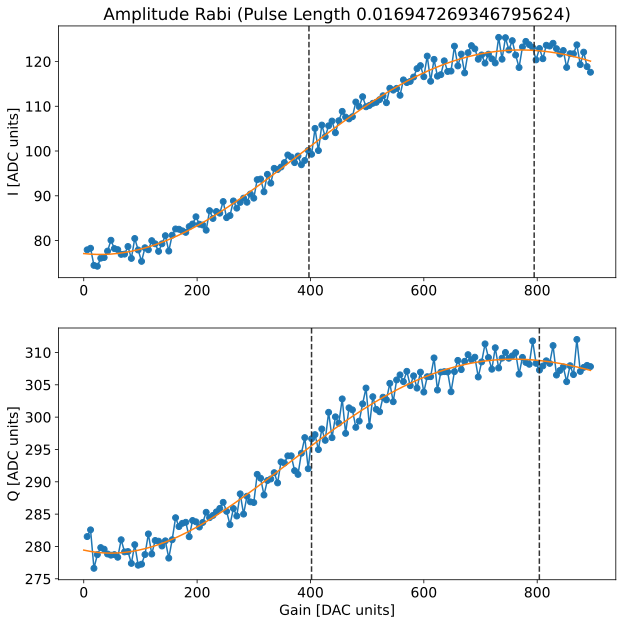

*Set Q1 pi pulse sigma with Q2 in e to 0.016947269346795624*
*Set Q1 pi pulse gain with Q2 in e to 796*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 3455.738449601716
Fit frequency from amps [MHz]: 1.4519676355708657 +/- 0.0016475874224251787
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3455.2864819661454
 	3453.2864819661454
T2 Ramsey from fit amps [us]: 7.933645931865751
Current pi pulse frequency: 3455.738449601716
Fit frequency from I [MHz]: 1.4511996291235278 +/- 0.0014741788999694052
Suggested new pi pulse frequency from fit I [MHz]:
 	3455.2872499725927
 	3453.2872499725927
T2 Ramsey from fit I [us]: 8.159233074831029
Fit frequency from Q [MHz]: 1.4523774073448206 +/- 0.0020671905698070618
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3455.286072194371
 	3453.286072194371
T2 Ramsey from fit Q [us]: 7.858377408444626


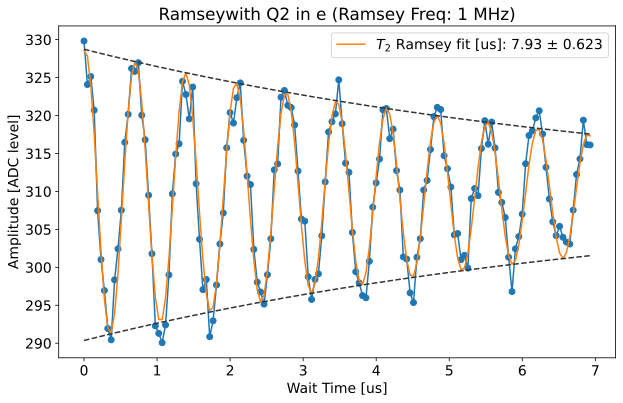

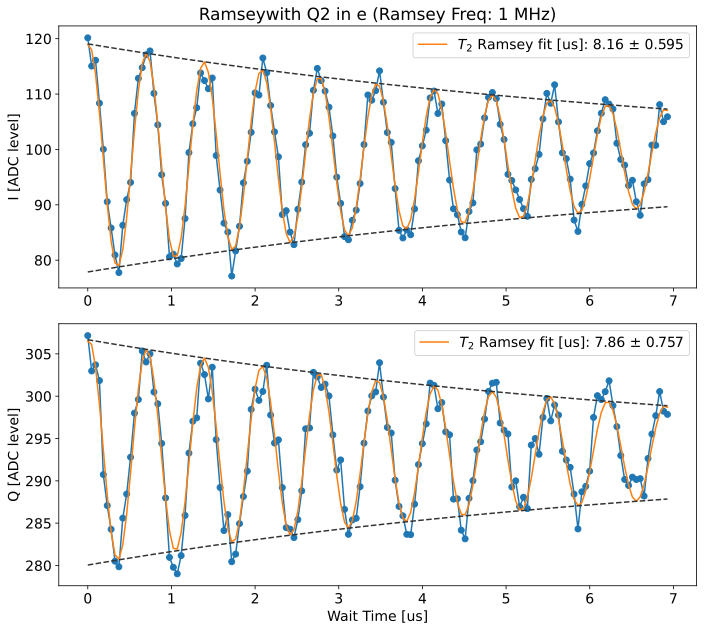

*Set Q1 pi pulse freq with Q2 in e to 3455.2872499725927*



######### BEGINNING QUBIT 3 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.39973169516973095
Pi length from avgi data [us]: 0.018818102502365288
	Pi/2 length from avgi data [us]: 0.009409051251182644

Decay from avgq [us] 0.3724088630630018
Pi length from avgq data [us]: 0.018329053529828002
Pi/2 length from avgq data [us]: 0.009164526764914001


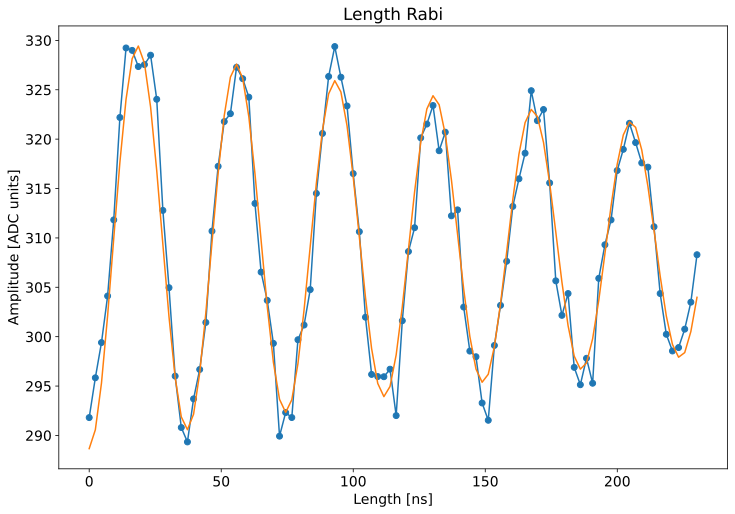

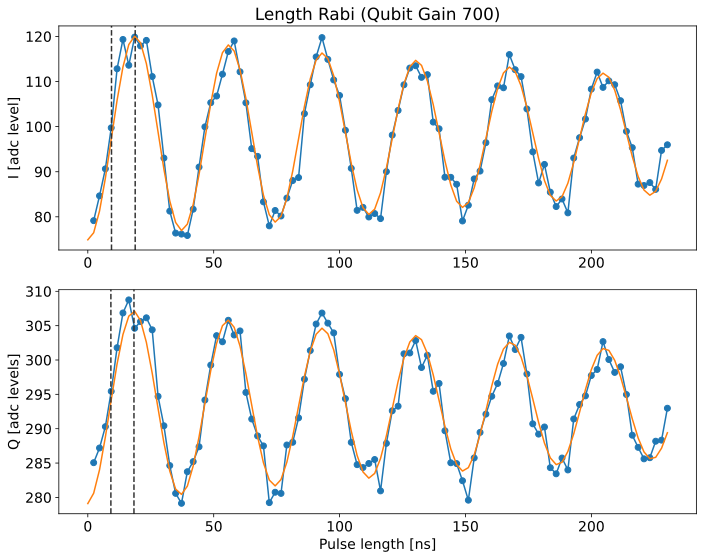

Will use sigma 0.01693629225212876 for amplitude rabi
-------- Amp rabi --------


  0%|          | 0/30 [00:00<?, ?it/s]

762
Attempted to init fitparam 4 to 102.36104541412497, which is out of bounds 275.6448327233293 to 310.29297166870003. Instead init to 292.96890219601465
Pi gain from amps data [dac units]: 834
	Pi/2 gain from amps data [dac units]: 417
Pi gain from avgi data [dac units]: 778
	Pi/2 gain from avgi data [dac units]: 389
Pi gain from avgq data [dac units]: 788
	Pi/2 gain from avgq data [dac units]: 394


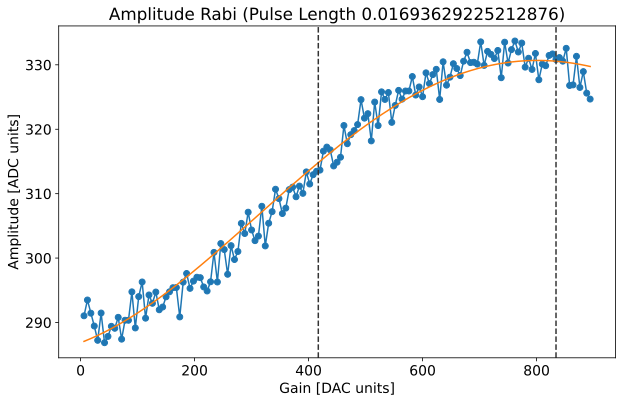

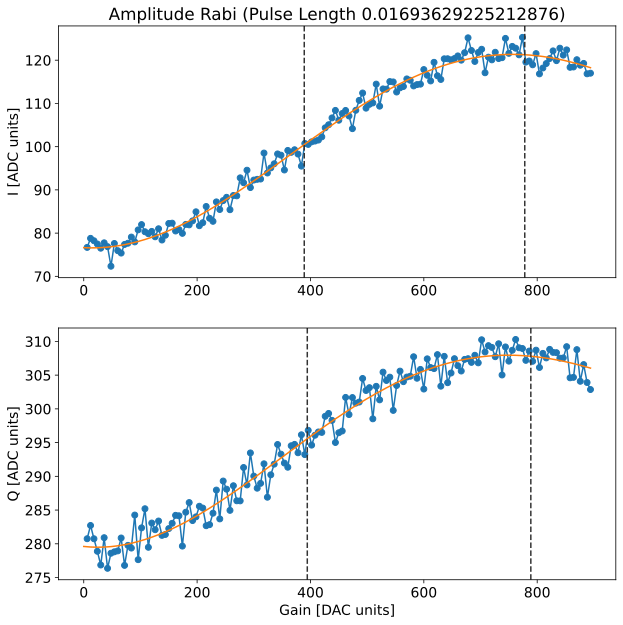

*Set Q1 pi pulse sigma with Q3 in e to 0.01693629225212876*
*Set Q1 pi pulse gain with Q3 in e to 834*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 3455.698976070442
Fit frequency from amps [MHz]: 1.6121669498158522 +/- 0.001655422071346033
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3455.086809120626
 	3453.086809120626
T2 Ramsey from fit amps [us]: 7.488049440882061
Current pi pulse frequency: 3455.698976070442
Fit frequency from I [MHz]: 1.6127510122388347 +/- 0.0016077714727768429
Suggested new pi pulse frequency from fit I [MHz]:
 	3455.086225058203
 	3453.086225058203
T2 Ramsey from fit I [us]: 7.834636860663208
Fit frequency from Q [MHz]: 1.6118367342472038 +/- 0.0019845043610800276
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3455.0871393361945
 	3453.0871393361945
T2 Ramsey from fit Q [us]: 7.327328017618395


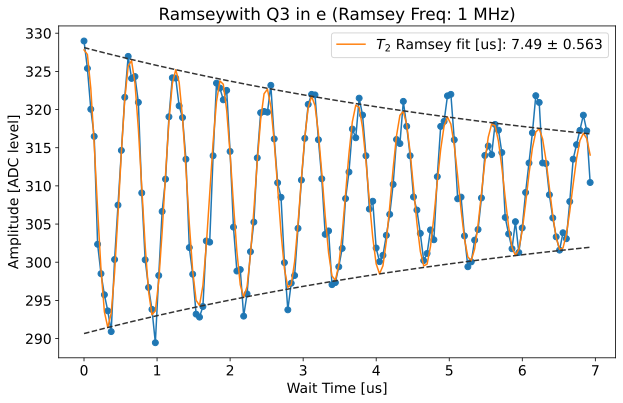

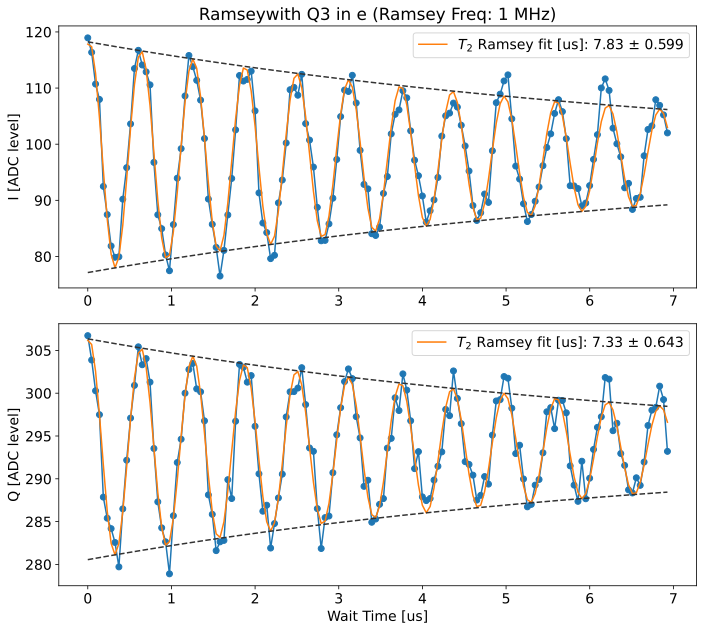

*Set Q1 pi pulse freq with Q3 in e to 3455.086225058203*





In [64]:
try: save_data
except:
    assert False, 'you did not run the cell above!'
q1 = 1
# for q0 in [1, 2, 3]:
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=2000,
        gain=yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0],
        pulse_type='gauss',
        qubits=[q0, q1],
        checkZZ=True,
        checkEF=False, 
    )

    try:
        import Pyro4.util
        try:
            lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        lengthrabiZZ.analyze(fit=True)
    
        lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
        lengthrabiZZ.display(fit=True)
        p = lengthrabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
        else: pi_len = (3/2 - p[2]/180)/2/p[1]
        pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
        lengthrabi_decay = p[3]

        print(f'Will use sigma {pi_len} for amplitude rabi')

        if save_data: saved_files.append(lengthrabiZZ.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{q1}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min(32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0])
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=30,
        sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
        results['sigma'][q0] =  pi_len
        print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
        results['gain'][q0] =  int(pi_gain)
        print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q1}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=1, # [MHz]
        reps=100,
        rounds=40,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, q1],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
        print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
        results['f_Q1_ZZ'][q0] =  new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
        continue
    
    print("\n\n")

In [65]:
print(results)
for saved_file in saved_files:
    print(saved_file)

{'gain': [864, 0, 796, 834], 'sigma': [0.017437897303316862, 0, 0.016947269346795624, 0.01693629225212876], 'f_Q1_ZZ': [3451.209771575993, 0, 3455.2872499725927, 3455.086225058203]}
